In [ ]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [ ]:
# Load data

DATADIR = "hackathon_data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
df = pd.read_csv(transactions_path)
balance = pd.read_csv('hackathon_data/avk_hackathon_data_account_x_balance.csv')

In [ ]:
# Get only needed columns and get rid of NaNs

df = df[['party_rk', 'transaction_dttm', 'transaction_amt_rur', 'category']].dropna()
df.head()

,party_rk,transaction_dttm,transaction_amt_rur,category
0,20337,2019-01-01,84.00,Сувениры
1,63404,2019-01-01,410.00,Фаст Фуд
2,24789,2019-01-01,701.44,Супермаркеты
3,57970,2019-01-01,6203.70,Дом/Ремонт
4,12232,2019-01-01,734.53,Супермаркеты


In [ ]:
# Initialize encoded data
# We encode each person by his/her spending in each category

NUMBER_OF_CLIENTS_TO_GET = 10000

ppl_ids = np.unique(df['party_rk'])[:NUMBER_OF_CLIENTS_TO_GET]
column_names = np.unique(df['category'])

encoded_data = pd.DataFrame(np.zeros((len(ppl_ids), len(column_names))), columns=column_names)
encoded_data = encoded_data.set_index(ppl_ids)
encoded_data.head()

,Duty Free,Авиабилеты,Автоуслуги,Аптеки,Аренда авто,Госсборы,Дом/Ремонт,Ж/д билеты,Животные,Искусство,...,Сувениры,Супермаркеты,Топливо,Транспорт,Турагентства,Фаст Фуд,Финансовые услуги,Фото/Видео,Цветы,Частные услуги
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Fill cells of dataframe with sum of money spent by categories

for id_ in tqdm(ppl_ids):
    series = df[df['party_rk'] == id_ ].groupby('category').sum()['transaction_amt_rur']
    encoded_data.at[id_ , series.index] = series.values

encoded_data.head()

100%|██████████| 10000/10000 [02:47<00:00, 59.64it/s]


,Duty Free,Авиабилеты,Автоуслуги,Аптеки,Аренда авто,Госсборы,Дом/Ремонт,Ж/д билеты,Животные,Искусство,...,Сувениры,Супермаркеты,Топливо,Транспорт,Турагентства,Фаст Фуд,Финансовые услуги,Фото/Видео,Цветы,Частные услуги
1,0.0,0.0,450.3,0.0,0.0,771.5,0.0,0.0,0.0,0.0,...,0.0,12233.20,3089.37,0.0,0.0,2259.0,34792.00,0.0,0.0,0.0
5,0.0,318006.0,14685.0,4109.4,0.0,0.0,25043.6,0.0,0.0,0.0,...,2488.0,124899.93,22440.08,9189.0,0.0,9070.0,595119.66,0.0,6200.0,0.0
7,0.0,0.0,0.0,6483.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2463.62,18623.57,0.0,0.0,0.0,0.00,0.0,0.0,0.0
8,0.0,0.0,0.0,650.0,0.0,0.0,69.0,0.0,0.0,0.0,...,0.0,968.00,0.00,0.0,0.0,3587.0,0.00,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1962.0,0.0,0.0,0.0,...,0.0,3763.96,0.00,1094.0,0.0,1729.0,6061.00,0.0,0.0,0.0


In [ ]:
# Create dataframe with euclidian distances to other people

from sklearn.metrics.pairwise import euclidean_distances

distances = pd.DataFrame(euclidean_distances(encoded_data, encoded_data),
                         columns=encoded_data.index.values, index=encoded_data.index.values)

distances.head()

,1,5,7,8,9,11,13,14,15,20,...,19009,19011,19016,19017,19020,19022,19023,19024,19026,19028
1,0.000000e+00,6.625185e+05,1.650585e+06,3.703332e+04,3.067177e+04,4.101391e+04,1.910171e+05,1.679934e+05,6.620083e+05,1.885277e+05,...,5.345015e+04,6.608094e+04,4.280805e+05,9.532085e+04,1.397242e+05,2.950514e+05,8.977425e+05,5.716378e+04,4.106541e+04,5.302596e+05
5,6.625185e+05,0.000000e+00,1.789958e+06,6.942083e+05,6.885317e+05,6.927041e+05,5.205059e+05,5.553216e+05,6.615326e+05,5.473086e+05,...,6.209227e+05,6.928765e+05,3.974920e+05,5.830872e+05,5.461223e+05,4.232623e+05,5.232040e+05,6.347281e+05,6.841604e+05,3.237486e+05
7,1.650585e+06,1.789958e+06,0.000000e+00,1.650226e+06,1.650238e+06,1.647356e+06,1.665373e+06,1.637471e+06,1.585012e+06,1.664443e+06,...,1.652474e+06,1.592807e+06,1.581501e+06,1.655393e+06,1.659362e+06,1.682877e+06,1.873781e+06,1.652346e+06,1.650549e+06,1.698874e+06
8,3.703332e+04,6.942083e+05,1.650226e+06,0.000000e+00,1.049464e+04,2.278595e+04,2.246129e+05,1.956613e+05,6.833801e+05,2.169522e+05,...,8.652193e+04,5.818528e+04,4.621892e+05,1.312651e+05,1.747467e+05,3.302178e+05,9.248504e+05,8.557749e+04,3.437665e+04,5.666129e+05
9,3.067177e+04,6.885317e+05,1.650238e+06,1.049464e+04,0.000000e+00,2.694626e+04,2.186112e+05,1.928012e+05,6.795962e+05,2.119564e+05,...,8.134426e+04,5.752006e+04,4.563724e+05,1.246814e+05,1.689361e+05,3.239565e+05,9.227541e+05,7.927679e+04,3.230103e+04,5.600875e+05


In [ ]:
# So the next function returns N nearest clients

def get_N_nearest(person_id, N=500):
    S = distances.loc[person_id]
    order = S.map(lambda x : x).abs().sort_values(ascending = True) # sort people by distance
    order_indexes = order.index[:min(N+1, len(order))][1:]
    return np.array(order_indexes)

In [ ]:
get_N_nearest(1)[:10]

array([ 5677,  5362,  6888,  4878, 15540,  4692,  1823,  6487,  9631,
        3084])

In [ ]:
# Let's find nearest clients for client 42

neighbors = get_N_nearest(42)

In [ ]:
# Get balances of this clients

interesting_balances = balance[balance['party_rk'].isin(neighbors)].dropna()
interesting_balances['prev_month'] = pd.to_datetime(interesting_balances['prev_month'], format="%Y-%m-%d")
interesting_balances['cur_month'] = pd.to_datetime(interesting_balances['cur_month'], format="%Y-%m-%d")

In [ ]:
# Find all clients, who have at least two months with positive 'balance_chng'
# and whose 'balance_chng' for that two months at least THRESHOLD rubles.
# And save those clients and their "good" months.

THRESHOLD = 10000

interesting_neighbors = {}
for indx in tqdm(neighbors):
    current_neighbor = interesting_balances[interesting_balances['party_rk'] == indx].sort_values(by='cur_month').reset_index()
    current_balance_chng = np.array(current_neighbor['balance_chng'])
    to_get = np.logical_and(
        current_balance_chng[1:] > 0,
        current_balance_chng[:-1] > 0,
        current_balance_chng[1:] + current_balance_chng[:-1] > THRESHOLD
    )
    if not np.any(to_get):
        continue
    good_months = current_neighbor.iloc[1:][to_get]
    interesting_neighbors[indx] = list()
    for _, row in good_months.iterrows():
        interesting_neighbors[indx].append(row['cur_month'])

100%|██████████| 500/500 [00:01<00:00, 391.44it/s]


In [ ]:
# Get ids (a.k.a. 'party_rk') of all interesting_neighbors

interesting_neighbors_id = list()
for k in interesting_neighbors.keys():
    interesting_neighbors_id.append(k)
interesting_neighbors_id = np.array(interesting_neighbors_id)

In [ ]:
# Get all transactions for the interesting_neighbors from their "good" months

interesting_transactions_df = df[
    ['party_rk', 'transaction_dttm', 'transaction_amt_rur', 'category']
][df['party_rk'].isin(interesting_neighbors_id)].dropna()
interesting_transactions_df['date'] = pd.to_datetime(interesting_transactions_df['transaction_dttm'])
interesting_transactions_df = interesting_transactions_df.drop(columns='transaction_dttm')

interesting_transactions = []
for current_neighbor_id, datetime_list in tqdm(interesting_neighbors.items()):
    current_neighbor_transactions = interesting_transactions_df[
        interesting_transactions_df['party_rk'] == current_neighbor_id
    ]
    for _, row in current_neighbor_transactions.iterrows():
        for current_datetime in datetime_list:
            if row['date'] <= current_datetime and row['date'] > current_datetime - pd.DateOffset(months=2):
                interesting_transactions.append(row)

interesting_transactions_df = pd.DataFrame(interesting_transactions)
interesting_transactions_df['year'] = interesting_transactions_df.date.dt.year
interesting_transactions_df['month'] = interesting_transactions_df.date.dt.month

100%|██████████| 222/222 [00:10<00:00, 20.27it/s]


In [ ]:
# save:
# interesting_transactions_df.to_csv('interesting_transactions.csv', index=False)

# load:
# interesting_transactions_df = pd.read_csv('interesting_transactions.csv')

In [ ]:
# Find the average spendings on each category for that interesting transactions per month

sums_df = interesting_transactions_df.groupby(
    ['party_rk', 'category', 'year', 'month']
).sum()['transaction_amt_rur'].reset_index()

means_df = sums_df.groupby(
    ['category', 'year', 'month']
).mean()['transaction_amt_rur'].reset_index()

In [ ]:
means_df[means_df['category'] == 'Фаст Фуд']

,category,year,month,transaction_amt_rur
314,Фаст Фуд,2019,1,1012.733333
315,Фаст Фуд,2019,2,1716.707692
316,Фаст Фуд,2019,3,1138.819167
317,Фаст Фуд,2019,4,1622.412222
318,Фаст Фуд,2019,5,2366.244762
319,Фаст Фуд,2019,6,1529.797647
320,Фаст Фуд,2019,7,1353.741786
321,Фаст Фуд,2019,8,1498.383333
322,Фаст Фуд,2019,9,1753.035294
323,Фаст Фуд,2019,10,1734.527647


In [ ]:
# Let's combine all previous cells into one function

THRESHOLD = 10000

def find_average_spendings(client_id, neighbors_num=None):
    if neighbors_num is None:
        neighbors = get_N_nearest(client_id)
    else:
        neighbors = get_N_nearest(client_id, neighbors_num)
    
    # Get balances of this clients
    interesting_balances = balance[balance['party_rk'].isin(neighbors)].dropna()
    interesting_balances['prev_month'] = pd.to_datetime(interesting_balances['prev_month'], format="%Y-%m-%d")
    interesting_balances['cur_month'] = pd.to_datetime(interesting_balances['cur_month'], format="%Y-%m-%d")

    # Find all clients, who have at least two months with positive 'balance_chng'
    # and whose 'balance_chng' for that two months at least THRESHOLD rubles.
    # And save those clients and their "good" months.
    interesting_neighbors = {}
    for indx in tqdm(neighbors):
        current_neighbor = interesting_balances[interesting_balances['party_rk'] == indx].sort_values(by='cur_month').reset_index()
        current_balance_chng = np.array(current_neighbor['balance_chng'])
        to_get = np.logical_and(
            current_balance_chng[1:] > 0,
            current_balance_chng[:-1] > 0,
            current_balance_chng[1:] + current_balance_chng[:-1] > THRESHOLD
        )
        if not np.any(to_get):
            continue
        good_months = current_neighbor.iloc[1:][to_get]
        interesting_neighbors[indx] = list()
        for _, row in good_months.iterrows():
            interesting_neighbors[indx].append(row['cur_month'])
    
    # Get ids (a.k.a. 'party_rk') of all interesting_neighbors
    interesting_neighbors_id = list()
    for k in interesting_neighbors.keys():
        interesting_neighbors_id.append(k)
    interesting_neighbors_id = np.array(interesting_neighbors_id)
    
    
    # Get all transactions for the interesting_neighbors from their "good" months
    interesting_transactions_df = df[
        ['party_rk', 'transaction_dttm', 'transaction_amt_rur', 'category']
    ][df['party_rk'].isin(interesting_neighbors_id)].dropna()
    interesting_transactions_df['date'] = pd.to_datetime(interesting_transactions_df['transaction_dttm'])
    interesting_transactions_df = interesting_transactions_df.drop(columns='transaction_dttm')

    interesting_transactions = []
    for current_neighbor_id, datetime_list in tqdm(interesting_neighbors.items()):
        current_neighbor_transactions = interesting_transactions_df[
            interesting_transactions_df['party_rk'] == current_neighbor_id
        ]
        for _, row in current_neighbor_transactions.iterrows():
            for current_datetime in datetime_list:
                if row['date'] <= current_datetime and row['date'] > current_datetime - pd.DateOffset(months=2):
                    interesting_transactions.append(row)

    interesting_transactions_df = pd.DataFrame(interesting_transactions)
    interesting_transactions_df['year'] = interesting_transactions_df.date.dt.year
    interesting_transactions_df['month'] = interesting_transactions_df.date.dt.month
    
    # Find the average spendings on each category for that interesting transactions per month
    sums_df = interesting_transactions_df.groupby(
        ['party_rk', 'category', 'year', 'month']
    ).sum()['transaction_amt_rur'].reset_index()
    means_df = sums_df.groupby(
        ['category', 'year', 'month']
    ).mean()['transaction_amt_rur'].reset_index()
    
    
    return means_df

In [ ]:
means_df = find_average_spendings(42)
means_df[means_df['category'] == 'Фаст Фуд']

100%|██████████| 222/222 [00:10<00:00, 21.87it/s]


,category,year,month,transaction_amt_rur
314,Фаст Фуд,2019,1,1012.733333
315,Фаст Фуд,2019,2,1716.707692
316,Фаст Фуд,2019,3,1138.819167
317,Фаст Фуд,2019,4,1622.412222
318,Фаст Фуд,2019,5,2366.244762
319,Фаст Фуд,2019,6,1529.797647
320,Фаст Фуд,2019,7,1353.741786
321,Фаст Фуд,2019,8,1498.383333
322,Фаст Фуд,2019,9,1753.035294
323,Фаст Фуд,2019,10,1734.527647


# Function to draw graphs

In [ ]:
def draw_customer_comparison(party_rk, means_df, category, all_transactions_df=None):
    FILL_BETWEEN_TICKS=1000
    if all_transactions_df is None:
        all_transactions_df = df

    mean = means_df[means_df['category'] == category][['year', 'month', 'transaction_amt_rur']]
    mean['month_str'] = mean.year.apply(str) + '-' + mean.month.apply(lambda x : str(x).zfill(2))
    mean = mean.drop(columns=['year', 'month'])

    client = all_transactions_df[all_transactions_df['party_rk'] == party_rk][
        ['category', 'transaction_dttm', 'transaction_amt_rur']
    ]
    client = client[client['category'] == category]
    client['date'] = pd.to_datetime(client['transaction_dttm'], format="%Y-%m-%d")
    client['month_str'] = client.date.dt.year.apply(str) + '-' + client.date.dt.month.apply(lambda x : str(x).zfill(2))
    client = client.groupby('month_str').sum()['transaction_amt_rur'].reset_index()

    months = np.unique(np.concatenate([mean['month_str'], client['month_str']]))  # unique returns sorted array
    month2id = {}
    for i, m in enumerate(months):
        month2id[m] = i    
    
    client_spendings = np.zeros(months.shape, dtype=np.float)
    for _, row in client.iterrows():
        client_spendings[month2id[row['month_str']]] = row['transaction_amt_rur']
    mean_spendings = np.zeros(months.shape, dtype=np.float)
    for _, row in mean.iterrows():
        mean_spendings[month2id[row['month_str']]] = row['transaction_amt_rur']

    
    client_spendings_filled = np.concatenate(
        [np.linspace(
            client_spendings[i],
            client_spendings[i + 1],
            num=FILL_BETWEEN_TICKS
        ) for i in range(client_spendings.shape[0] - 1)]
    )
    mean_spendings_filled = np.concatenate(
        [np.linspace(
            mean_spendings[i],
            mean_spendings[i + 1],
            num=FILL_BETWEEN_TICKS
        ) for i in range(mean_spendings.shape[0] - 1)]
    )
    
    fig, ax = plt.subplots()

    x = np.arange(client_spendings_filled.shape[0])
    ax.fill_between(x, mean_spendings_filled, client_spendings_filled,
                    where=mean_spendings_filled > client_spendings_filled,
                    color='g', alpha=0.4)
    
    ax.fill_between(x, mean_spendings_filled, client_spendings_filled,
                    where=client_spendings_filled > mean_spendings_filled,
                    color='r', alpha=0.4)

    ax.fill_between(x, 0, mean_spendings_filled,
                    where=mean_spendings_filled <= client_spendings_filled,
                    color='b', alpha=0.5)
    ax.fill_between(x, 0, client_spendings_filled,
                    where=client_spendings_filled <= mean_spendings_filled,
                    color='b', alpha=0.5)

    ax.plot(x, client_spendings_filled, label='client', color='black', linestyle='-')
    ax.plot(x, mean_spendings_filled, label='mean', color='black', linestyle=':')

    plt.xlabel('month')
    plt.ylabel('rubles')
    plt.xticks([i * FILL_BETWEEN_TICKS for i in range(len(months))], months, rotation=45)
    plt.legend()
    plt.show()

100%|██████████| 291/291 [00:32<00:00,  9.06it/s]


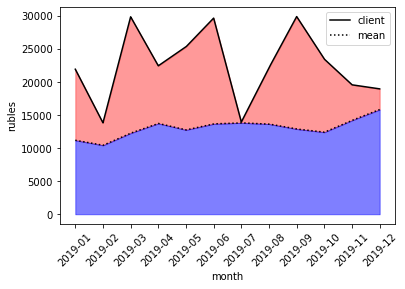

In [ ]:
draw_customer_comparison(555, find_average_spendings(555), 'Супермаркеты')

100%|██████████| 222/222 [00:10<00:00, 21.09it/s]


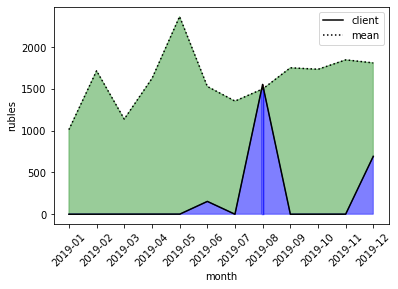

In [ ]:
draw_customer_comparison(42, find_average_spendings(42), 'Фаст Фуд')

100%|██████████| 222/222 [00:10<00:00, 20.73it/s]


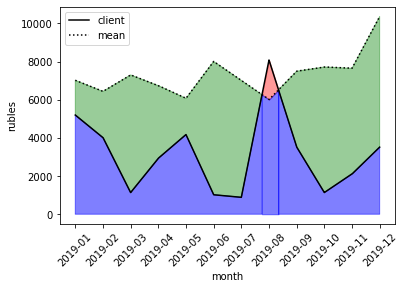

In [ ]:
draw_customer_comparison(42, find_average_spendings(42), 'Супермаркеты')

100%|██████████| 222/222 [00:09<00:00, 24.43it/s]


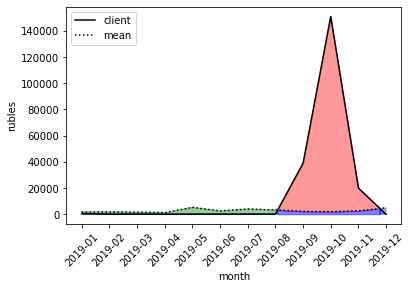

In [ ]:
draw_customer_comparison(42, find_average_spendings(42), 'Красота')